<a href="https://colab.research.google.com/github/Pushkal-B/QRCODE/blob/main/cheqr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Install the python-chess library with SVG support
!pip install python-chess
!pip install cairosvg
!pip install opencv-python
!pip install numpy
!pip install python-chess


# Import necessary libraries
import chess
import chess.svg
import math
from IPython.display import display, SVG
import base64
import cairosvg
import cv2
import numpy as np

Enter the data to encode into the chessboard: abcdefghijklmnopqrstuvwxyz


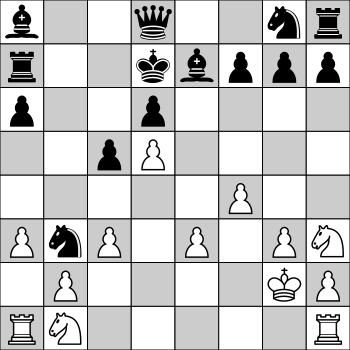

Chessboard image saved as 'chessboard.png'

Decoded Data: abcdefghijklmnopqrstuvwxyz


In [49]:


# Function to encode data into a sequence of legal chess moves
def encode_data_into_moves(data):
    board = chess.Board()  # Start from the standard initial position
    moves = []
    data_bytes = data.encode('utf-8')
    data_bits = ''.join(format(byte, '08b') for byte in data_bytes)
    data_index = 0

    while data_index < len(data_bits):
        # Get the list of legal moves in the current position
        legal_moves = sorted(list(board.legal_moves), key=lambda m: m.uci())  # Consistent ordering
        num_moves = len(legal_moves)
        bits_per_move = math.floor(math.log2(num_moves))
        if bits_per_move == 0:
            raise ValueError("No legal moves available to encode data.")

        # Extract bits from data_bits
        bits_to_read = bits_per_move
        bits = data_bits[data_index:data_index + bits_to_read]
        if len(bits) < bits_per_move:
            # Pad with zeros if necessary
            bits = bits.ljust(bits_per_move, '0')
        data_index += bits_per_move

        # Convert bits to an index
        move_index = int(bits, 2)
        if move_index >= num_moves:
            move_index = num_moves - 1  # Adjust if out of bounds

        # Select the move and apply it
        move = legal_moves[move_index]
        board.push(move)
        moves.append(move)

        # Check for game over
        if board.is_game_over():
            break

    return moves

# Function to decode data from a sequence of moves
def decode_data_from_moves(moves):
    board = chess.Board()
    data_bits = ''
    for move in moves:
        legal_moves = sorted(list(board.legal_moves), key=lambda m: m.uci())  # Consistent ordering
        num_moves = len(legal_moves)
        bits_per_move = math.floor(math.log2(num_moves))
        if bits_per_move == 0:
            break  # No data can be encoded here

        # Find the index of the move in the list of legal moves
        move_index = legal_moves.index(move)
        # Convert index to bits
        bits = format(move_index, f'0{bits_per_move}b')
        data_bits += bits

        board.push(move)

        # Check for game over
        if board.is_game_over():
            break

    # Convert bits to bytes
    data_bytes = int(data_bits, 2).to_bytes((len(data_bits) + 7) // 8, byteorder='big')
    # Decode bytes to string, ignoring padding zeros
    data = data_bytes.rstrip(b'\x00').decode('utf-8', errors='ignore')
    return data

# Function to display and save the final chess position with gray and white squares and black grid lines
def display_and_save_chess_position_with_grid(board, size=350, filename='chessboard.png'):
    # Define custom styles for squares and pieces with grid lines
    style = """
    .square {
        stroke: #000000;  /* Black grid lines */
        stroke-width: 1px;
    }
    .square.light { fill: #FFFFFF; }  /* Light squares are white */
    .square.dark { fill: #CCCCCC; }   /* Dark squares are light gray */
    """

    svg_board = chess.svg.board(
        board=board,
        size=size,
        coordinates=False,
        style=style
    )
    # Display the SVG in the notebook
    display(SVG(svg_board))

    # Save the SVG to a file
    svg_filename = 'chessboard.svg'
    with open(svg_filename, 'w') as f:
        f.write(svg_board)

    # Convert SVG to PNG using cairosvg
    cairosvg.svg2png(url=svg_filename, write_to=filename)
    print(f"Chessboard image saved as '{filename}'")

# Prompt the user to enter the data to encode
data = input("Enter the data to encode into the chessboard: ")

# Encode the data into moves
moves = encode_data_into_moves(data)

# Reconstruct the board from the moves
board = chess.Board()
for move in moves:
    board.push(move)

# Display and save the final position with gray and white squares and black grid lines
display_and_save_chess_position_with_grid(board, size=350, filename='chessboard.png')  # Adjust the size parameter as needed

# Decode the data
decoded_data = decode_data_from_moves(moves)
print("\nDecoded Data:", decoded_data)


# Decoding